In [1]:
# In case you want to change the deepxde default backend just run the following line and select the backend at the end of the line:
# source: https://www.kaggle.com/code/lucasscheink/tesis-2d

# !python /Users/vassilis/anaconda3/pkgs/deepxde-1.9.3-pyhd5b0024_0/site-packages/deepxde/backend/set_default_backend.py tensorflow

In [2]:
import deepxde as dde
import numpy as np
import pandas as pd
import scipy as sp
from math import exp
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import os
import re

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
os.getcwd()

'/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation'

Here we define the parameters that we want to estimate.

In [4]:
# Parameters to be estimated.

# P_liver = dde.Variable(1.0)
# P_muscle = dde.Variable(1.0)
# P_kidney = dde.Variable(1.0)
P_skin = dde.Variable(0.5)
# P_gills = dde.Variable(1.0)
# P_carcass = dde.Variable(1.0)
# P_viscera = dde.Variable(1.0)

Now we can begin by creating a TimeDomain class.

In [5]:
geom = dde.geometry.TimeDomain(0, 56*24)

In [6]:
# Function to estimate the constant parameters of the model
def create_params(substance, Texp):
    # Transform input temperature into Kelvin scale
    Texp = 273 + Texp  # K

    Tref = 273 + np.array([6, 12, 18])  # Reference Temperature K - Grech et al. 2018
    keep_ref_value = np.argmin(np.abs(Tref - Texp))

    # Cardiac output reference value at T = 6 C (Barron et al. 1987, Table II)
    F_card_ref_6 = 1.188  # ml/h/g
    # Cardiac output reference value at T = 12 C (Barron et al. 1987, Table II)
    F_card_ref_12 = 2.322  # ml/h/g
    # Cardiac output reference value at T = 18 C (Barron et al. 1987, Table II)
    F_card_ref_18 = 3.75  # ml/h/g
    F_card_ref_values = [F_card_ref_6, F_card_ref_12, F_card_ref_18]
    F_card_ref = F_card_ref_values[keep_ref_value]

    # Body weight reference value at T = 6 C (Barron et al. 1987, Table II)
    BW_ref_6 = 270.1  # g
    # Body weight reference value at T = 12 C (Barron et al. 1987, Table II)
    BW_ref_12 = 296.4  # g
    # Body weight reference value at T = 18 C (Barron et al. 1987, Table II)
    BW_ref_18 = 414.5  # g
    BW_ref_values = [BW_ref_6, BW_ref_12, BW_ref_18]
    BW_ref = BW_ref_values[keep_ref_value]

    # Arrhenius Temperature function
    TA = 6930  # Arrhenius Temperature K - Grech et al. 2018
    Tr = Tref[np.argmin(np.abs(Tref - Texp))]
    KT = exp(TA / Tr - TA / Texp)

    # Load the xlsx file with the physiological params of rainbow trout
    phys_params_sheet1 = pd.read_excel('/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/Rainbow trout Physiological parameters/Rainbow trout Physiological parameters.xlsx', sheet_name=0)

    # Keep only the physiological parameters from the paper of Vidal et al. 2019
    fw = phys_params_sheet1.loc[phys_params_sheet1['Source'] == 'Vidal et al. 2019', ['Liver', 'Blood', 'Skin', 'Muscle', 'Gills', 'Kidney', 'Viscera']]
    fw_Liver = fw['Liver'].values[0]
    fw_Blood = fw['Blood'].values[0]
    fw_Skin = fw['Skin'].values[0]
    fw_Muscle = fw['Muscle'].values[0]
    fw_Gills = fw['Gills'].values[0]
    fw_Kidney = fw['Kidney'].values[0]
    fw_Viscera = fw['Viscera'].values[0]
    fw_lumen = 0.012

    # Load the xlsx file with the physiological params of rainbow trout
    phys_params_sheet2 = pd.read_excel('/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/Rainbow trout Physiological parameters/Rainbow trout Physiological parameters.xlsx', sheet_name=1)

    # Keep only the physiological parameters from the paper of Vidal et al. 2019
    fb = phys_params_sheet2.loc[phys_params_sheet2['Source'] == 'Vidal et al. 2019', ['Liver', 'Skin', 'Muscle', 'Gills', 'Kidney', 'Viscera']]
    fb_Liver = fb['Liver'].values[0]
    fb_Skin = fb['Skin'].values[0]
    fb_Muscle = fb['Muscle'].values[0]
    fb_Gills = fb['Gills'].values[0]
    fb_Kidney = fb['Kidney'].values[0]
    fb_Viscera = fb['Viscera'].values[0]

    # Reabsorption coefficients from bile to intestine
    # estimated by Cao et al., 2022
    # K_urine = Cl_urine / f_reab_urine estimated by Ng et al., 2013 (unitless)
    if substance == 'PFOA':
        a = 0.138  # Sun et al., 2022, Goeritz et al. 2013
        f_reab_hep = 0.30  # Cao et al., 2022
        K_urine = 2.08
        Cl_urine = 0.029 * 3600  # 1/h (Sun et al., 2022)
    elif substance == 'PFNA':
        a = 0.522  # Sun et al., 2022, Goeritz et al. 2013
        f_reab_hep = 0.34  # Cao et al., 2022
        K_urine = 1.35
        Cl_urine = 0.050 * 3600  # 1/h (Sun et al., 2022)
    elif substance == 'PFBS':
        a = 0.0598  # Goeritz et al. 2013
        f_reab_hep = 0.23  # Cao et al., 2022
        K_urine = 5.88
        Cl_urine = 0.023 * 3600  # 1/h (Sun et al., 2022) # Assumed equal to PFHxS
    elif substance == 'PFHxS':
        a = 0.558  # Sun et al., 2022, Goeritz et al. 2013
        f_reab_hep = 0.30  # Cao et al., 2022
        K_urine = 5.88
        Cl_urine = 0.023 * 3600  # 1/h (Sun et al., 2022)
    elif substance == 'PFOS':
        a = 0.721  # Sun et al., 2022, Goeritz et al. 2013
        f_reab_hep = 0.42  # Cao et al., 2022
        K_urine = 1.35
        Cl_urine = 0.050 * 3600  # 1/h (Sun et al., 2022)

    # Bile flow coefficient
    Q_bile_coef = 7.5e-05  # ml/g BW/h Grosell et al., 2000
    Q_urine_coef = 2.755e-03  # ml/h/g of BW Urinary flow rate (Curtis et al., 1981)
    V_urine_coef = 2.2e-03  # ml/g of BW Urine volume inside urinary bladder (Curtis et al., 1981)

    a_skin = 0.9  # 90% of venous blood of skin was assumed to flow directly to kidney (Nichols et al. 1996)
    a_muscle = 0.6  # 60% of venous blood of muscle was assumed to flow directly to kidney (Nichols et al. 1996)

    plasma = 0.7
    
    return[F_card_ref, BW_ref, KT, fw_Liver, fw_Blood, fw_Skin, fw_Muscle, fw_Gills, fw_Kidney,
          fw_Viscera, fw_lumen, fb_Liver, fb_Skin, fb_Muscle, fb_Gills, fb_Kidney, fb_Viscera,
          a_skin, a_muscle, Q_bile_coef, Q_urine_coef, V_urine_coef, 
          K_urine, Cl_urine, f_reab_hep,plasma,a]

In [7]:
def fish_weight(time):
    x = tf.constant([0, 28 * 24, 56 * 24], dtype=tf.float32)
    y = tf.constant([314, 655, 808], dtype=tf.float32)

    w = tf.zeros([1,1])

    for time_i in tf.unstack(time):
        time_i = tf.cast(time_i, 'float32')
        condition_1 = tf.math.less_equal(time_i, tf.cast(x[0], 'float32'))
        condition_2 = tf.math.greater_equal(time_i, tf.cast(x[2], 'float32'))
        condition_3 = tf.math.logical_and(tf.math.greater_equal(time_i, tf.cast(x[0], 'float32')), tf.math.less(time_i, tf.cast(x[1], 'float32')))
        condition_4 = tf.math.logical_and(tf.math.greater_equal(time_i, tf.cast(x[1], 'float32')), tf.math.less(time_i, tf.cast(x[2], 'float32')))
        
        w_new = tf.cond(condition_1, lambda: y[0], 
                         lambda: tf.cond(condition_2, lambda: y[2], 
                                         lambda: tf.cond(condition_3, 
                                                         lambda: tfp.math.interp_regular_1d_grid(tf.cast(time_i, 'float32'), tf.cast(x[0], 'float32'),  
                                                                 tf.cast(x[1], 'float32'), tf.cast(y[0:2], 'float32')), 
                                                         lambda: tfp.math.interp_regular_1d_grid(tf.cast(time_i, 'float32'), tf.cast(x[1], 'float32'), 
                                                                    tf.cast(x[2], 'float32'), tf.cast(y[1:3], 'float32')) ))) 
        
        w_new = tf.reshape(w_new, [-1,1])
        w = tf.concat([w, w_new], axis=0)   
    w = w[1:]
    return (w)

Next, we create the PBK model to solve using the dde.grad.jacobian function.

In [8]:
def PBK_model(t, net_out, ex):
    # At this point we estimate the derivatives of the networks outputs to time    
    M_art, M_venous, M_gills, M_lumen, M_lumen_2, M_viscera, M_liver, M_kidney, \
    M_muscle, M_skin, M_carcass, M_storage, M_urine, M_feces, \
    C_gills, C_viscera, C_liver, C_kidney, C_muscle, C_skin, C_carcass, \
    C_lumen, C_art, C_venous, C_blood, C_storage= net_out[:, 0:1], net_out[:, 1:2], \
    net_out[:, 2:3], net_out[:, 3:4], net_out[:, 4:5], net_out[:, 5:6], net_out[:, 6:7], net_out[:, 7:8], \
    net_out[:, 8:9], net_out[:, 9:10], net_out[:, 10:11], net_out[:, 11:12], net_out[:, 12:13], net_out[:, 13:14],  \
    net_out[:, 14:15], net_out[:, 15:16], net_out[:, 16:17], net_out[:, 17:18], net_out[:, 18:19], net_out[:, 19:20], net_out[:, 20:21], \
    net_out[:, 21:22], net_out[:, 22:23], net_out[:, 23:24], net_out[:, 24:25], net_out[:, 25:26]
    
    dM_art_ls = dde.gradients.jacobian(net_out, t, i=0)
    dM_venous_ls = dde.gradients.jacobian(net_out, t, i=1)
    dM_gills_ls = dde.gradients.jacobian(net_out, t, i=2)
    dM_lumen_ls = dde.gradients.jacobian(net_out, t, i=3)
    dM_lumen_2_ls = dde.gradients.jacobian(net_out, t, i=4)
    dM_viscera_ls = dde.gradients.jacobian(net_out, t, i=5)
    dM_liver_ls = dde.gradients.jacobian(net_out, t, i=6)
    dM_kidney_ls = dde.gradients.jacobian(net_out, t, i=7)
    dM_muscle_ls = dde.gradients.jacobian(net_out, t, i=8)
    dM_skin_ls = dde.gradients.jacobian(net_out, t, i=9)
    dM_carcass_ls = dde.gradients.jacobian(net_out, t, i=10)
    dM_storage_ls = dde.gradients.jacobian(net_out, t, i=11)
    dM_urine_ls = dde.gradients.jacobian(net_out, t, i=12)
    dM_feces_ls = dde.gradients.jacobian(net_out, t, i=13)
    
    dC_gills_ls = dde.gradients.jacobian(net_out, t, i=14)
    dC_viscera_ls = dde.gradients.jacobian(net_out, t, i=15)
    dC_liver_ls = dde.gradients.jacobian(net_out, t, i=16)
    dC_kidney_ls = dde.gradients.jacobian(net_out, t, i=17)
    dC_muscle_ls = dde.gradients.jacobian(net_out, t, i=18)
    dC_skin_ls = dde.gradients.jacobian(net_out, t, i=19)
    dC_carcass_ls = dde.gradients.jacobian(net_out, t, i=20)
    dC_lumen_ls = dde.gradients.jacobian(net_out, t, i=21)
    dC_art_ls = dde.gradients.jacobian(net_out, t, i=22)
    dC_venous_ls = dde.gradients.jacobian(net_out, t, i=23)
    dC_blood_ls = dde.gradients.jacobian(net_out, t, i=24)
    dC_storage_ls = dde.gradients.jacobian(net_out, t, i=25)

    
    #------------------------------------------------------------
    # Estimate the derivatives based on the ODEs.
    
    # Estimation of constant parameters 
    (F_card_ref,BW_ref,KT,fw_Liver,fw_Blood,fw_Skin,fw_Muscle,fw_Gills,
     fw_Kidney, fw_Viscera, fw_lumen,fb_Liver,fb_Skin,fb_Muscle,fb_Gills,
     fb_Kidney,fb_Viscera,a_skin,a_muscle,Q_bile_coef,
     Q_urine_coef,V_urine_coef,K_urine,Cl_urine,f_reab_hep,plasma, a) = create_params('PFOS', 15)
    
    CLU_coef = 0.0005719031
    Ku = 1.4668919575
    Cl_feces = 1.3064647362
    
    P_liver = 1.5685318
    P_muscle = 0.11316576
    P_kidney = 0.4398762
    # P_skin = 0.2715996
    P_gills = 0.2291869
    P_carcass = 0.1074253
    P_viscera = 3.699111
    
    # Body weight - g
    BW = fish_weight(t)
    
    # Total cardiac output ml/h considered as plasma flow
    Q_total = F_card_ref*KT*(BW/BW_ref)**(-0.1)*BW*plasma  
    
    # Calculate the mass of each tissue - g
    w_blood = fw_Blood*BW*plasma     # Blood mass - g
    w_liver = fw_Liver*BW     # Liver mass - g
    w_skin = fw_Skin*BW       # Skin weight - g
    w_muscle = fw_Muscle*BW   # Muscle weight - g
    w_gills = fw_Gills*BW     # Gills weight - g
    w_kidney = fw_Kidney*BW   # Kidney weight - g
    w_viscera = fw_Viscera*BW # Viscera weight - g
    w_lumen = fw_lumen*BW
    w_art = 1/3*w_blood
    w_venous = 2/3*w_blood
    w_carcass = BW - (w_blood/plasma + w_liver + w_skin + w_muscle +
                         w_gills + w_kidney + w_viscera + w_lumen)
    
    # Calculate the regional blood flows - ml/h
    Q_liver = fb_Liver*Q_total     # Liver blood flow - ml/h
    Q_skin = fb_Skin*Q_total      # Skin blood flow - ml/h
    Q_muscle = fb_Muscle*Q_total   # Muscle blood flow - ml/h
    Q_gills = Q_total #fb_Gills*BW     # Gills blood flow - ml/h
    Q_kidney = fb_Kidney*Q_total   # Kidney blood flow - ml/h
    Q_viscera = fb_Viscera*Q_total # Viscera blood flow - ml/h
    Q_carcass = Q_total - (Q_liver + Q_skin + Q_muscle + 
                              Q_kidney + Q_viscera)
    
    # Calculate the absolute bile flow rate - ml/h
    Q_bile = Q_bile_coef*BW
    # Calculate Urinary flow rate - ml/h
    Q_urine = Q_urine_coef*BW
    
    # Calculate urine volume  - ml 
    v_urine = V_urine_coef*BW
    
    # Calculate f_reab_urine based on Cl_urine and K_urine - 1/h
    f_reab_urine = Cl_urine*CLU_coef/K_urine
    
    # Tissue concentrations ug PFAS/g tissue
    # C_gills = M_gills/w_gills
    # C_viscera = M_viscera/w_viscera
    # C_liver = M_liver/w_liver
    # C_kidney = M_kidney/w_kidney
    # C_muscle = M_muscle/w_muscle 
    # C_skin = M_skin/w_skin
    # C_carcass = M_carcass/w_carcass
    # C_lumen = (M_lumen+M_lumen_2)/w_lumen
    # C_art = M_art/w_art
    # C_venous = M_venous/w_venous
    # C_blood = (M_art + M_venous)/w_blood
    # C_storage = M_storage/v_urine
    
    # Arterial Blood
    dM_art_rs = Q_gills*C_gills/P_gills - \
                (Q_viscera + Q_liver + Q_kidney +
                 Q_muscle + Q_skin + Q_carcass)*C_art
    dC_art_rs = dM_art_rs/w_art
        
    # Venous blood    
    dM_venous_rs = - Q_total*C_venous + \
                    (Q_liver + Q_viscera)*C_liver/P_liver + \
                    (Q_kidney + a_muscle*Q_muscle + a_skin*Q_skin)*C_kidney/P_kidney + \
                    (1-a_muscle)*Q_muscle*C_muscle/P_muscle + \
                    (1-a_skin)*Q_skin*C_skin/P_skin + Q_carcass*C_carcass/P_carcass
    dC_venous_rs = dM_venous_rs/w_venous
    
    dC_blood_rs = (dM_art_rs + dM_venous_rs)*plasma/w_blood
    
    # Gills 
    dM_gills_rs = Q_gills*(C_venous - C_gills/P_gills) 
    dC_gills_rs = dM_gills_rs/w_gills 
    
    
    # Viscera Lumen - Available PFAS for absorption and elimination
    dM_lumen_rs = - Ku*a*M_lumen - Cl_feces*(1-a)*M_lumen + ex
    
    # Viscera Lumen 2 - Unavailable PFAS for absorption. Can be only eliminated.
    dM_lumen_2_rs = (1-f_reab_hep)*Q_bile*C_liver - Cl_feces*M_lumen_2 
    
    dC_lumen_rs = (dM_lumen_rs + dM_lumen_2_rs)/w_lumen
    
    
    # Viscera Tissue
    dM_viscera_rs = Q_viscera*(C_art - C_viscera/P_viscera) + Ku*a*M_lumen + \
                      f_reab_hep*Q_bile*C_liver
    dC_viscera_rs = dM_viscera_rs/w_viscera
    
    # Liver
    dM_liver_rs = Q_liver*C_art + Q_viscera*C_viscera/P_viscera -    \
                      (Q_liver + Q_viscera)*C_liver/P_liver - Q_bile*C_liver
    dC_liver_rs = dM_liver_rs/w_liver
        
    # Kidney
    dM_kidney_rs = Q_kidney*C_art -   \
                  (Q_kidney + a_muscle*Q_muscle + a_skin*Q_skin)*C_kidney/P_kidney + \
                  a_muscle*Q_muscle*C_muscle/P_muscle +   \
                  a_skin*Q_skin*C_skin/P_skin - Cl_urine*CLU_coef*M_kidney + f_reab_urine*M_storage
    
    dC_kidney_rs = dM_kidney_rs/w_kidney
                
    # Muscle 
    dM_muscle_rs = Q_muscle*(C_art - C_muscle/P_muscle)
    dC_muscle_rs = dM_muscle_rs/w_muscle

    # Skin
    dM_skin_rs = Q_skin*(C_art - C_skin/P_skin)
    dC_skin_rs = dM_skin_rs/w_skin
    
    # Carcass 
    dM_carcass_rs = Q_carcass*(C_art - C_carcass/P_carcass)
    dC_carcass_rs = dM_carcass_rs/w_carcass
    
    # Urine Storage
    dM_storage_rs = Cl_urine*CLU_coef*M_kidney - f_reab_urine*M_storage - Q_urine*C_storage
    dC_storage_rs = dM_storage_rs/v_urine
    
    # Urine
    dM_urine_rs = Q_urine*C_storage
    
    # Feces
    dM_feces_rs = Cl_feces*((1-a)*M_lumen + M_lumen_2)
    
    return [
        dM_art_ls - dM_art_rs,
        dM_venous_ls - dM_venous_rs,
        dM_gills_ls - dM_gills_rs,
        dM_lumen_ls - dM_lumen_rs,
        dM_lumen_2_ls - dM_lumen_2_rs,
        dM_viscera_ls - dM_viscera_rs,
        dM_liver_ls - dM_liver_rs,
        dM_kidney_ls - dM_kidney_rs,
        dM_muscle_ls - dM_muscle_rs,
        dM_skin_ls - dM_skin_rs,
        dM_carcass_ls - dM_carcass_rs,
        dM_storage_ls - dM_storage_rs,
        dM_urine_ls - dM_urine_rs,
        dM_feces_ls - dM_feces_rs,
        
        dC_gills_ls - dC_gills_rs,
        dC_viscera_ls - dC_viscera_rs,
        dC_liver_ls - dC_liver_rs,
        dC_kidney_ls - dC_kidney_rs,
        dC_muscle_ls - dC_muscle_rs,
        dC_skin_ls - dC_skin_rs,
        dC_carcass_ls - dC_carcass_rs,
        dC_lumen_ls - dC_lumen_rs,
        dC_art_ls - dC_art_rs,
        dC_venous_ls - dC_venous_rs,
        dC_blood_ls - dC_blood_rs,
        dC_storage_ls - dC_storage_rs
    ]

Next, we consider the initial conditions. We need to implement a function, which should return True for points inside the subdomain and False for the points outside.

In [9]:
def boundary(_, on_initial):
    return on_initial

In [10]:
# Initial conditions

ic1 = dde.icbc.IC(geom, lambda X: 0, boundary, component=0) # M_art
ic2 = dde.icbc.IC(geom, lambda X: 0, boundary, component=1) # M_venous
ic3 = dde.icbc.IC(geom, lambda X: 0, boundary, component=2) # M_gills
ic4 = dde.icbc.IC(geom, lambda X: 0, boundary, component=3) # M_lumen <<--- The initial added PFAS amount.
ic5 = dde.icbc.IC(geom, lambda X: 0, boundary, component=4) # M_lumen_2
ic6 = dde.icbc.IC(geom, lambda X: 0, boundary, component=5) # M_viscera
ic7 = dde.icbc.IC(geom, lambda X: 0, boundary, component=6) # M_liver
ic8 = dde.icbc.IC(geom, lambda X: 0, boundary, component=7) # M_kidney
ic9 = dde.icbc.IC(geom, lambda X: 0, boundary, component=8) # M_muscle
ic10 = dde.icbc.IC(geom, lambda X: 0, boundary, component=9) # M_skin
ic11 = dde.icbc.IC(geom, lambda X: 0, boundary, component=10) # M_carcass
ic12 = dde.icbc.IC(geom, lambda X: 0, boundary, component=11) # M_storage
ic13 = dde.icbc.IC(geom, lambda X: 0, boundary, component=12) # M_urine
ic14 = dde.icbc.IC(geom, lambda X: 0, boundary, component=13) # M_feces

ic15 = dde.icbc.IC(geom, lambda X: 0, boundary, component=14) # C_gills
ic16 = dde.icbc.IC(geom, lambda X: 0, boundary, component=15) # C_viscera
ic17 = dde.icbc.IC(geom, lambda X: 0, boundary, component=16) # C_liver
ic18 = dde.icbc.IC(geom, lambda X: 0, boundary, component=17) # C_kidney
ic19 = dde.icbc.IC(geom, lambda X: 0, boundary, component=18) # C_muscle
ic20 = dde.icbc.IC(geom, lambda X: 0, boundary, component=19) # C_skin
ic21 = dde.icbc.IC(geom, lambda X: 0, boundary, component=20) # C_carcass
ic22 = dde.icbc.IC(geom, lambda X: 0, boundary, component=21) # C_lumen
ic23 = dde.icbc.IC(geom, lambda X: 0, boundary, component=22) # C_art
ic24 = dde.icbc.IC(geom, lambda X: 0, boundary, component=23) # C_venous
ic25 = dde.icbc.IC(geom, lambda X: 0, boundary, component=24) # C_blood
ic26 = dde.icbc.IC(geom, lambda X: 0, boundary, component=25) # C_storage


In [11]:
def gen_traindata():
    #data = np.load('PFOS_dataset.npy')
    data = pd.read_csv('PFOS_dataset_2.csv')
    return np.vstack(data["Time"]), np.vstack(data["Liver"]), np.vstack(data["Blood"]), np.vstack(data["Skin"]), \
            np.vstack(data["Muscle"]), np.vstack(data["Gills"]), np.vstack(data["Kidney"]), np.vstack(data["Carcass"])

In [12]:
pd.read_csv('PFOS_dataset_2.csv')

,Column1,Substance,Time,Cumulative_added_PFAS,Feeding_period,Depuration_period,Liver,Blood,Skin,Muscle,Gills,Kidney,Carcass
0,2,PFOS,168,31.89875,168,0,0.173413,0.110337,0.035337,0.028029,0.035337,0.060721,0.014183
1,3,PFOS,336,71.55525,336,0,0.305289,0.145674,0.052982,0.028750,0.041827,0.106827,0.019904
2,4,PFOS,672,174.14150,672,0,0.463269,0.237885,0.094808,0.052115,0.059038,0.159808,0.038269
3,5,PFOS,744,174.14150,0,72,0.377864,0.200941,0.071326,0.026326,0.050556,0.132095,0.026326
4,6,PFOS,840,174.14150,0,168,0.337837,0.136683,0.074375,0.019375,0.054760,0.102453,0.030145
5,7,PFOS,1008,174.14150,0,336,0.193942,0.090481,0.031634,0.012019,0.030481,0.055481,0.013173
6,8,PFOS,1344,174.14150,0,672,0.186923,0.041923,0.017308,0.004231,0.021154,0.030001,0.006923


In [13]:
# data = pd.read_csv('PFOS_dataset_2.csv')
# data = data[["Time", 'Liver', 'Blood', 'Skin', 'Muscle', 'Gills', 'Kidney', 'Carcass']]
# data[['Time']] = (data[['Time']] - data[['Time']].min()) / (data[['Time']].max() - data[['Time']].min())
# data
# #data_norm = (data - data.min()) / (data.max() - data.min())
# #data_norm

In [14]:
observe_t, C_liver, C_blood, C_skin, C_muscle, C_gills, C_kidney, C_carcass = gen_traindata()
# observe_t, C_liver, C_blood, C_skin, C_muscle, C_gills, C_kidney, C_carcass = np.vstack(data["Time"]), np.vstack(data["Liver"]), np.vstack(data["Blood"]), np.vstack(data["Skin"]), \
#             np.vstack(data["Muscle"]), np.vstack(data["Gills"]), np.vstack(data["Kidney"]), np.vstack(data["Carcass"])

observe_Blood = dde.icbc.PointSetBC(observe_t, C_blood, component=24, shuffle=False) 
observe_Gills = dde.icbc.PointSetBC(observe_t, C_gills, component=14, shuffle=False)
observe_Liver = dde.icbc.PointSetBC(observe_t, C_liver, component=16, shuffle=False)
observe_Kidney = dde.icbc.PointSetBC(observe_t, C_kidney, component=17, shuffle=False)
observe_Muscle = dde.icbc.PointSetBC(observe_t, C_muscle, component=18, shuffle=False)
observe_Skin = dde.icbc.PointSetBC(observe_t, C_skin, component=19, shuffle=False)
observe_Carcass = dde.icbc.PointSetBC(observe_t, C_carcass, component=20,shuffle=False)

Import the data for events.

In [15]:
events_data = pd.read_csv('events_simplified.csv')
time_points = np.vstack(events_data['time'])
added_amount = np.vstack(events_data['value'])

# Create an interpolation function to approximate the events_data governing function

# def ex_func(t):
#     spline = sp.interpolate.RBFInterpolator(time_points, added_amount, kernel = 'thin_plate_spline')
#     return spline(t[:, 0:])

# def ex_func(t): 
#     added_pfas = []
#     for time_i in t:
#         if np.isin(time_i, time_points):
#             index = np.where(np.isin(time_points, time_i))
#             added_pfas.append(added_amount[index])
#         else:
#             added_pfas.append(0)
#     return(np.vstack(added_pfas))

def ex_func(t): 
    added_pfas = []
    for time_i in t:
        if time_i <= 648:
            added_pfas.append(6.449685/24)
        else:
            added_pfas.append(0)
    return(np.vstack(added_pfas))

In [16]:
print(events_data.shape)
print(time_points.shape)
print(added_amount.shape)

(28, 2)
(28, 1)
(28, 1)


In [17]:
# events_time_points = time_points

# anchors = np.concatenate((events_time_points, observe_t))
anchors = observe_t
anchors = np.sort(anchors, axis=0)
anchors = np.vstack(np.unique(anchors))

In [18]:
# Now that the problem is fully setup, we define the PDE as:
# ic1, ic2, ic3, ic4, ic5, ic6, ic7, ic8, ic9, ic10, ic11,
#            ic12, ic13, ic14, ic15, ic16, ic17, ic18, ic19, ic20, ic21,
#            ic22, ic23, ic24, ic25, ic26,
# data = dde.data.PDE(
#     geometry = geom, # Instance of Geometry
#     pde = PBK_model, # A global PDE or a list of PDEs. None if no global PDE.
#     bcs = [observe_Blood, observe_Gills, observe_Liver, observe_Kidney,
#            observe_Muscle, observe_Skin, observe_Carcass], #A boundary condition or a list of boundary conditions. Use [] if no boundary condition.
#     num_domain=1000, # The number of training points sampled inside the domain.
#     num_test= 100, 
#     num_boundary=2, # The number of training points sampled on the boundary.
#     train_distribution = 'uniform', # The distribution to sample training points.
#     anchors=anchors, # A Numpy array of training points, in addition to the num_domain and num_boundary sampled points.
#     auxiliary_var_function = ex_func)

data = dde.data.PDE(
    geometry = geom, # Instance of Geometry
    pde = PBK_model, # A global PDE or a list of PDEs. None if no global PDE.
    bcs = [observe_Skin], #A boundary condition or a list of boundary conditions. Use [] if no boundary condition.
    num_domain=2000, # The number of training points sampled inside the domain.
    num_test= 100, 
    num_boundary=7, # The number of training points sampled on the boundary.
    #train_distribution = 'uniform', # The distribution to sample training points.
    anchors=anchors, # A Numpy array of training points, in addition to the num_domain and num_boundary sampled points.
    auxiliary_var_function = ex_func)

In [19]:
# data = dde.data.PDE(
#     geometry = geom, # Instance of Geometry
#     pde = PBK_model, # A global PDE or a list of PDEs. None if no global PDE.
#     bcs = [observe_Blood, observe_Gills, observe_Liver, observe_Kidney,
#            observe_Muscle, observe_Skin, observe_Carcass], #A boundary condition or a list of boundary conditions. Use [] if no boundary condition.
#     num_domain=50, # The number of training points sampled inside the domain.
#     num_boundary=2, # The number of training points sampled on the boundary.
#     train_distribution = 'uniform', # The distribution to sample training points.
#     anchors=anchors, # A Numpy array of training points, in addition to the num_domain and num_boundary sampled points.
#     auxiliary_var_function = ex_func)

In [20]:
def output_transform(t, netout):
    netout1 = netout[:, 0:1]
    netout2 = netout[:, 1:2]
    netout3 = netout[:, 2:3]
    netout4 = netout[:, 3:4]
    netout5 = netout[:, 4:5]
    netout6 = netout[:, 5:6]
    netout7 = netout[:, 6:7]
    netout8 = netout[:, 7:8]
    netout9 = netout[:, 8:9]
    netout10 = netout[:, 9:10]
    netout11 = netout[:, 10:11]
    netout12 = netout[:, 11:12]
    netout13 = netout[:, 12:13]
    netout14 = netout[:, 13:14]
    netout15 = netout[:, 14:15]
    netout16 = netout[:, 15:16]
    netout17 = netout[:, 16:17]
    netout18 = netout[:, 17:18]
    netout19 = netout[:, 18:19]
    netout20 = netout[:, 19:20]
    netout21 = netout[:, 20:21]
    netout22 = netout[:, 21:22]
    netout23 = netout[:, 22:23]
    netout24 = netout[:, 23:24]
    netout25 = netout[:, 24:25]
    netout26 = netout[:, 25:26]
    
    return tf.concat(
        [netout1 * tf.tanh(t) , netout2 * tf.tanh(t), netout3 * tf.tanh(t),
         netout4 * tf.tanh(t), 
         netout5 * tf.tanh(t), netout6 * tf.tanh(t),
         netout7 * tf.tanh(t) , netout8 * tf.tanh(t), netout9 * tf.tanh(t),
         netout10 * tf.tanh(t), netout11 * tf.tanh(t), netout12 * tf.tanh(t),
         netout13 * tf.tanh(t), netout14 * tf.tanh(t), netout15 * tf.tanh(t),
         netout16 * tf.tanh(t), netout17 * tf.tanh(t), netout18 * tf.tanh(t),
         netout19 * tf.tanh(t), netout20 * tf.tanh(t), netout21 * tf.tanh(t),
         netout22 * tf.tanh(t), netout23 * tf.tanh(t), netout24 * tf.tanh(t),
         netout25 * tf.tanh(t), netout26 * tf.tanh(t)
        ], axis=1
    )

In [21]:
# Next, we choose the network. 

initializer = tf.keras.initializers.GlorotNormal(seed = 1)
net = dde.nn.FNN([1] + [30] * 5 + [26], "tanh", initializer)
net.apply_output_transform(output_transform)


model = dde.Model(data, net)

external_trainable_variables=[P_skin]
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue(external_trainable_variables, period=1000, filename="variables.dat")

In [22]:
loss_weights = np.concatenate((np.repeat([0.1], 26), np.repeat([10],1)) )

In [23]:
optimizer = tf.keras.optimizers.Adam()
lr=0.01
loss = dde.losses.mean_squared_error

model.compile(optimizer = optimizer, lr=lr, loss = loss, #loss_weights = loss_weights.tolist(),
              external_trainable_variables=external_trainable_variables)

Compiling model...
'compile' took 0.000233 s



In [24]:
losshistory, train_state = model.train(iterations=40000, callbacks=[variable])

Training model...



2023-09-18 11:06:03.775668: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Step      Train loss                                                                                                                                                                                                                                                                        Test loss                                                                                                                                                                                                                                                                         Test metric
0         [3.07e+06, 4.59e+04, 5.83e+06, 1.17e-01, 1.13e-01, 1.03e+03, 1.44e+01, 1.03e+07, 2.18e+07, 1.33e+04, 5.63e+05, 8.76e-02, 1.48e-01, 1.44e-01, 3.49e+04, 9.41e-01, 3.87e-01, 1.01e+05, 1.74e+02, 7.82e+00, 3.07e+01, 1.06e-02, 6.69e+04, 4.38e+02, 2.78e+03, 4.66e-02, 2.37e-01]    [3.08e+06, 4.54e+04, 5.84e+06, 1.17e-01, 1.13e-01, 1.03e+03, 1.44e+01, 1.03e+07, 2.18e+07, 1.34e+04, 5.64e+05, 8.78e-02, 1.48e-01, 1.45e-01, 3.50e

2023-09-18 11:07:21.326569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradients/fnn/strided_slice_grad/StridedSliceGrad_grad/StridedSlice/gradients/fnn/strided_slice_grad/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{{node gradients/gradients/fnn/strided_slice_grad/StridedSliceGrad_grad/StridedSlice/gradients/fnn/strided_slice_grad/StridedSliceGrad/strides}}]]
2023-09-18 11:07:21.327606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradients/fnn/strided_slice_1_grad/StridedSliceGrad_grad/StridedSlice/gradients/fnn/strided_slice_1_grad/StridedSliceGrad/strides' with dtype int

1000      [4.59e+00, 4.87e+00, 2.89e+00, 2.87e-02, 1.16e-03, 8.27e-01, 3.16e-02, 2.31e+00, 2.96e+00, 2.31e+01, 7.39e+00, 2.06e-04, 4.32e-04, 1.13e-03, 6.85e-02, 2.96e-03, 2.61e-03, 8.66e-02, 7.53e-05, 5.43e-02, 1.37e-03, 3.91e-04, 3.44e-01, 9.17e-02, 4.50e-02, 1.77e-04, 2.23e-03]    [3.04e+00, 4.85e+00, 1.00e+00, 2.85e-02, 1.16e-03, 6.99e-01, 2.00e-02, 5.86e-01, 2.99e+00, 1.79e+01, 7.21e+00, 2.05e-04, 4.33e-04, 1.13e-03, 2.08e-02, 2.45e-03, 1.00e-03, 1.98e-02, 7.70e-05, 4.06e-02, 1.33e-03, 3.51e-04, 1.88e-01, 9.06e-02, 3.79e-02, 1.76e-04, 2.23e-03]    []  
2000      [9.81e-01, 1.34e+00, 1.12e+00, 2.06e-02, 1.18e-04, 4.59e-01, 1.43e-02, 6.55e-01, 1.11e+00, 1.25e+01, 4.00e+00, 1.74e-04, 3.59e-04, 1.95e-04, 2.67e-02, 1.69e-03, 7.09e-04, 2.33e-02, 2.77e-05, 2.92e-02, 7.56e-04, 7.04e-04, 7.78e-02, 2.43e-02, 1.53e-02, 1.55e-04, 2.32e-03]    [8.02e-01, 1.15e+00, 1.55e+00, 2.03e-02, 1.16e-04, 4.34e-01, 1.04e-02, 3.82e-01, 1.00e+00, 1.12e+01, 3.78e+00, 1.72e-04, 3.59e-04, 1.91e-04, 3.69e-02, 1.

Saving loss history to /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/loss.dat ...
Saving training data to /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/train.dat ...
Saving test data to /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/test.dat ...


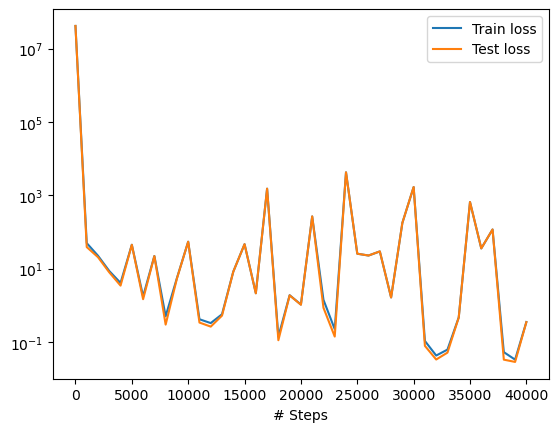

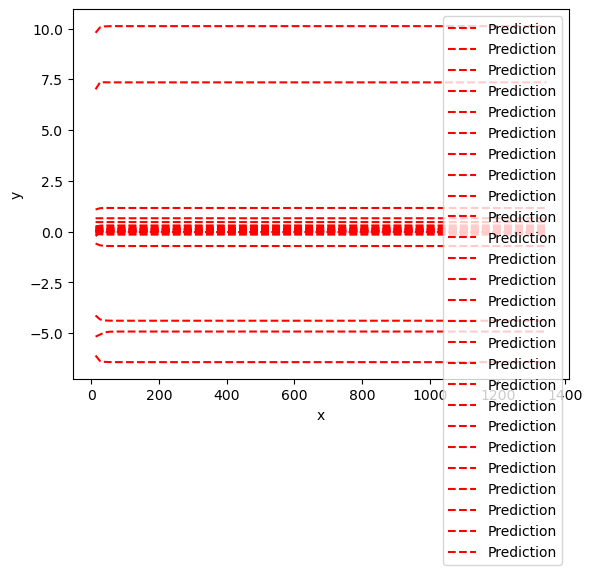

In [30]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [31]:
model.state_dict()

{'external_trainable_variable:0': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.6792906>,
 'denses.0.kernel': <tf.Variable 'fnn/dense/kernel:0' shape=(1, 30) dtype=float32, numpy=
 array([[ 0.06716698, -0.09270946,  0.11257049, -0.33814734, -0.06402378,
         -0.05376808, -0.06972161,  0.06321869,  0.05761669, -0.15632206,
          0.44560122, -0.17726074,  0.09542727,  0.07242284, -0.06048359,
         -0.07595126, -0.11479294, -0.132653  ,  0.05120556, -0.13701652,
          0.11887617,  0.08758842, -0.06056883,  0.22707418,  0.11697692,
          0.14423236,  0.10728766,  0.09703943,  0.07705349, -0.70450044]],
       dtype=float32)>,
 'denses.0.bias': <tf.Variable 'fnn/dense/bias:0' shape=(30,) dtype=float32, numpy=
 array([ 0.25285128,  0.12778996, -0.02912554, -0.33007038,  0.3039588 ,
         0.05641022,  0.04437551, -0.03819786,  0.21074493, -0.3568925 ,
         0.0915683 , -0.1401704 , -0.02433573,  0.10460083, -0.09423798,
        -0.16222365, -0.28498846, -

In [27]:
model.predict(time_points)


array([[-0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 9.20554876e-01, -4.72835541e-01, -7.02816062e-03,
         8.44796747e-02, -7.75469281e-03, -6.32164097e+00,
        -5.55219507e+00,  4.04934259e-03, -4.15669394e+00,
         7.88820314e+00,  9.97616959e+00, -9.68240425e-02,
         9.10338536e-02,  5.26438594e-01,  3.99872437e-02,
         6.50042653e-01,  2.71530420e-01,  7.66324326e-02,
         1.97743829e-02,  1.18845016e-01,  1.85418539e-02,
         3.49611193e-01,  1.74257889e-01,  1.74021900e-01,
        -1.31

In [28]:
test_data = np.genfromtxt('test.dat',
                     skip_header=0,
                     skip_footer=0,
                     names=None,
                     dtype=None,
                     delimiter=' ')
test_data

array([[ 1.68000000e+02,  1.16456485e+00, -7.08378375e-01, ...,
         1.77332237e-01, -1.45785868e-01,  2.02549761e-03],
       [ 3.36000000e+02,  1.16456485e+00, -7.08378375e-01, ...,
         1.77332237e-01, -1.45785868e-01,  2.02549761e-03],
       [ 6.72000000e+02,  1.16456485e+00, -7.08378375e-01, ...,
         1.77332237e-01, -1.45785868e-01,  2.02549761e-03],
       ...,
       [ 1.30407922e+03,  1.16456509e+00, -7.08378553e-01, ...,
         1.77332282e-01, -1.45785898e-01,  2.02549808e-03],
       [ 1.31738611e+03,  1.16456509e+00, -7.08378553e-01, ...,
         1.77332282e-01, -1.45785898e-01,  2.02549808e-03],
       [ 1.33069312e+03,  1.16456509e+00, -7.08379030e-01, ...,
         1.77332282e-01, -1.45786047e-01,  2.02560145e-03]])

In [29]:
columns_names=['Time', 'M_art', 'M_venous', 'M_gills', 'M_lumen', 'M_lumen_2', 'M_viscera', 'M_liver', 'M_kidney', \
    'M_muscle', 'M_skin', 'M_carcass', 'M_storage', 'M_urine', 'M_feces', \
    'C_gills', 'C_viscera', 'C_liver', 'C_kidney', 'C_muscle', 'C_skin', 'C_carcass', \
    'C_lumen', 'C_art', 'C_venous', 'C_blood', 'C_storage']
test_df = pd.DataFrame(test_data, columns = columns_names)
test_df

,Time,M_art,M_venous,M_gills,M_lumen,M_lumen_2,M_viscera,M_liver,M_kidney,M_muscle,...,C_liver,C_kidney,C_muscle,C_skin,C_carcass,C_lumen,C_art,C_venous,C_blood,C_storage
0,168.000000,1.164565,-0.708378,-0.020277,0.082164,-0.007861,-6.424502,-4.918353,-0.022826,-4.385550,...,0.279283,0.077979,0.020066,0.119853,0.019042,0.303879,0.177318,0.177332,-0.145786,0.002025
1,336.000000,1.164565,-0.708378,-0.020277,0.082164,-0.007861,-6.424502,-4.918353,-0.022826,-4.385550,...,0.279283,0.077979,0.020066,0.119853,0.019042,0.303879,0.177318,0.177332,-0.145786,0.002025
2,672.000000,1.164565,-0.708378,-0.020277,0.082164,-0.007861,-6.424502,-4.918353,-0.022826,-4.385550,...,0.279283,0.077979,0.020066,0.119853,0.019042,0.303879,0.177318,0.177332,-0.145786,0.002025
3,744.000000,1.164565,-0.708378,-0.020277,0.082164,-0.007861,-6.424502,-4.918353,-0.022826,-4.385550,...,0.279283,0.077979,0.020066,0.119853,0.019042,0.303879,0.177318,0.177332,-0.145786,0.002025
4,840.000000,1.164565,-0.708378,-0.020277,0.082164,-0.007861,-6.424502,-4.918353,-0.022826,-4.385550,...,0.279283,0.077979,0.020066,0.119853,0.019042,0.303879,0.177318,0.177332,-0.145786,0.002025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,1277.465332,1.164565,-0.708378,-0.020277,0.082164,-0.007861,-6.424502,-4.918353,-0.022826,-4.385550,...,0.279283,0.077979,0.020066,0.119853,0.019042,0.303879,0.177318,0.177332,-0.145786,0.002025
103,1290.772217,1.164565,-0.708378,-0.020277,0.082164,-0.007861,-6.424502,-4.918353,-0.022826,-4.385550,...,0.279283,0.077979,0.020066,0.119853,0.019042,0.303879,0.177318,0.177332,-0.145786,0.002025
104,1304.079224,1.164565,-0.708379,-0.020277,0.082164,-0.007861,-6.424503,-4.918354,-0.022826,-4.385551,...,0.279283,0.077979,0.020066,0.119853,0.019042,0.303879,0.177318,0.177332,-0.145786,0.002025
105,1317.386108,1.164565,-0.708379,-0.020277,0.082164,-0.007861,-6.424503,-4.918354,-0.022826,-4.385551,...,0.279283,0.077979,0.020066,0.119853,0.019042,0.303879,0.177318,0.177332,-0.145786,0.002025
